In [13]:
import os
import pandas as pd

csv_path = os.path.join('../data/FAR-Trans/close_prices.csv')
close_df = pd.read_csv(csv_path)
close_df['timestamp'] = pd.to_datetime(close_df['timestamp'])
close_df.head()

,ISIN,timestamp,closePrice
0,100974271034,2018-01-02,3.33
1,100974271034,2018-01-03,3.33
2,100974271034,2018-01-04,3.43
3,100974271034,2018-01-05,3.48
4,100974271034,2018-01-08,3.63


In [14]:
# Configuration
CSV_PATH = "'/content/drive/My Drive/bt4103 capstone (just us)/2. datasets/FAR-Trans/close_prices.csv'"  # Optional: path to CSV with columns ['ISIN','timestamp','closePrice']
FILL_GAP_MAX = 10           # fill gaps ≤ this length (business days)
MIN_DAYS = 100              # keep stocks with ≥ MIN_DAYS data after gap handling
D1 = 25                     # input lookback days
D2 = 5                      # output horizon days
SELECTED_ISIN = None        # e.g., "100974271034"; if None, first column will be used
RANDOM_SEED = 42

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)

# Try to use existing close_df; otherwise read from CSV_PATH
try:
    close_df  # noqa: F821
except NameError:
    if not CSV_PATH:
        raise ValueError("close_df not found in session. Set CSV_PATH to your data file path.")
    close_df = pd.read_csv(CSV_PATH)
    close_df.columns = close_df.columns.str.strip()
    if "timestamp" in close_df.columns:
        close_df["timestamp"] = pd.to_datetime(close_df["timestamp"], errors="coerce")

# Basic checks
required_cols = {"ISIN","timestamp","closePrice"}
missing = required_cols - set(close_df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

close_df = close_df.copy()
close_df = close_df.sort_values(["ISIN","timestamp"])
print(close_df.head())
print(f"Unique ISIN count: {close_df['ISIN'].nunique()}")


           ISIN  timestamp  closePrice
0  100974271034 2018-01-02        3.33
1  100974271034 2018-01-03        3.33
2  100974271034 2018-01-04        3.43
3  100974271034 2018-01-05        3.48
4  100974271034 2018-01-08        3.63
Unique ISIN count: 807


In [16]:
# Define holidays (month-day strings)
HOLIDAYS = {"01-01", "12-25"}

def is_holiday(date: pd.Timestamp) -> bool:
    return date.strftime("%m-%d") in HOLIDAYS

## 1) Pivot & Gap Handling (fill ≤10, else drop head/tail gaps)

from collections import defaultdict

def check_and_fill_series(s: pd.Series, fill_gap_max: int):
    s = s.copy()
    is_na = s.isna().astype(int)
    grp = (is_na.diff(1) != 0).cumsum()
    bad = False

    for g_id, idx in s.groupby(grp).groups.items():
        vals = s.loc[idx]
        if vals.isna().all():
            # exclude holidays from the run
            valid_idx = [d for d in idx if not is_holiday(d)]
            run_len = len(valid_idx)

            # If nothing left (all holiday gaps), skip
            if run_len == 0:
                continue

            # Head gap → drop
            if valid_idx[0] == s.index[0]:
                bad = True
                break

            # Tail gap → drop
            if valid_idx[-1] == s.index[-1]:
                bad = True
                break

            # Internal gap → fill only if short enough
            if run_len <= fill_gap_max:
                prev_val = s.loc[:valid_idx[0]].ffill().iloc[-1]
                s.loc[valid_idx] = prev_val
            else:
                bad = True
                break

    if bad:
        return None
    return s.ffill()

# Reindex each ISIN to business days, fill or drop
filled = {}
dropped = []
gap_report = defaultdict(list)

for isin, g in close_df.groupby("ISIN"):
    g = g.sort_values("timestamp")
    # Business-day index for that stock's span
    bidx = pd.bdate_range(g["timestamp"].min(), g["timestamp"].max())
    s = g.set_index("timestamp")["closePrice"].reindex(bidx)

    # Track gap lengths
    na_runs = s.isna().astype(int)
    gap_report[isin] = []
    if na_runs.sum() > 0:
        grp = (na_runs.diff(1) != 0).cumsum()
        for g_id, idx in s.groupby(grp).groups.items():
            vals = s.loc[idx]
            if vals.isna().all():
                gap_report[isin].append(len(vals))

    # Fill or drop
    s_filled = check_and_fill_series(s, FILL_GAP_MAX)
    if s_filled is None:
        dropped.append(isin)
    else:
        filled[isin] = s_filled.rename(isin)

print(f"Stocks dropped due to head/tail/long gaps: {len(dropped)}")
if dropped:
    print(list(dropped)[:10], "...")

# Build pivot (outer join across retained ISINs, aligned to union of their calendars)
pivot_df = pd.concat(filled.values(), axis=1).sort_index()

# Drop holidays (01-01 and 12-25)
pivot_df = pivot_df[~pivot_df.index.strftime("%m-%d").isin(["01-01", "12-25"])]

print("Pivot shape (days × ISINs):", pivot_df.shape)

# Report only ISINs that had at least one INTERNAL gap (ignoring holidays)
internal_gap_stocks = []
for isin, g in close_df.groupby("ISIN"):
    g = g.sort_values("timestamp")
    bidx = pd.bdate_range(g["timestamp"].min(), g["timestamp"].max())
    s = g.set_index("timestamp")["closePrice"].reindex(bidx)

    is_na = s.isna().astype(int)
    grp = (is_na.diff(1) != 0).cumsum()
    for g_id, idx in s.groupby(grp).groups.items():
        vals = s.loc[idx]
        if vals.isna().all():
            # drop holidays from this missing run
            valid_idx = [d for d in idx if not is_holiday(d)]

            # If after excluding holidays, no true missing days → skip this run
            if not valid_idx:
                continue

            # If there are still real missing days → check head/tail
            if valid_idx[0] != s.index[0] and valid_idx[-1] != s.index[-1]:
                internal_gap_stocks.append(isin)
                break  # only need to mark once per ISIN

print(f"Stocks that had internal gaps (ignoring holidays): {len(internal_gap_stocks)}")
print(internal_gap_stocks[:20])


Stocks dropped due to head/tail/long gaps: 0
Pivot shape (days × ISINs): (1275, 807)
Stocks that had internal gaps (ignoring holidays): 0
[]


In [17]:
# Filter stocks with at least MIN_DAYS non-null values
valid_counts = pivot_df.notna().sum()
kept_isins = valid_counts[valid_counts >= MIN_DAYS].index.tolist()
pivot_df = pivot_df[kept_isins]
pivot_df = pivot_df.ffill().bfill()
print(f"Kept ISINs (≥{MIN_DAYS} days): {len(kept_isins)}")

# Simple scaling by max per stock (preserve scaler for inverse transform)
stock_mean = pivot_df.mean(skipna=True)
stock_std = pivot_df.std(skipna=True).replace(0, 1)
scaled_close = (pivot_df - stock_mean) / stock_std

# Returns for volatility (daily percent change); volatility = rolling std of returns
returns = scaled_close.pct_change(fill_method=None)

def rolling_features(df, windows=(5,10,20)):
    feats = {}
    for w in windows:
        feats[f"ma{w}"] = df.rolling(w, min_periods=w).mean()
    for w in windows:
        feats[f"vol{w}"] = returns.rolling(w, min_periods=w).std()
    return feats

features = rolling_features(scaled_close)
# Keep original scaled close as a feature
features = {"close": scaled_close, **features}

# Combine into 3D tensor: align on common dates where all features available
feat_frames = list(features.values())
aligned = pd.concat(feat_frames, axis=1, keys=list(features.keys()))

# Drop rows only before the largest rolling window
max_window = 20
aligned = aligned.iloc[max_window:]   # ensures all ma/vol features are defined

# Drop any rows where *all* ISINs are NaN (shouldn't usually happen after pivot)
aligned = aligned.dropna(how="all")

dates = aligned.index

# Build tensor: (days, isins, features)
isin_list = kept_isins
feat_names = list(features.keys())
num_days = len(dates)
num_isins = len(isin_list)
num_features = len(feat_names)

tensor = np.empty((num_days, num_isins, num_features), dtype=np.float32)
for f_idx, fname in enumerate(feat_names):
    df_f = aligned[fname][isin_list]
    tensor[:,:,f_idx] = df_f.to_numpy()

print("Tensor shape (days, isins, features):", tensor.shape)
print("Features:", feat_names)


Kept ISINs (≥100 days): 769
Tensor shape (days, isins, features): (1255, 769, 7)
Features: ['close', 'ma5', 'ma10', 'ma20', 'vol5', 'vol10', 'vol20']


In [18]:
# Check for exact zeros in the tensor
zero_mask = (tensor == 0)

total_zeros = zero_mask.sum()
print(f"Total zeros in tensor: {total_zeros}")

# Breakdown by feature
for f_idx, fname in enumerate(feat_names):
    n_zeros = zero_mask[:,:,f_idx].sum()
    print(f"Feature '{fname}': {n_zeros} zeros")

# Optional: check if any ISIN column is entirely zero for some feature
for f_idx, fname in enumerate(feat_names):
    all_zero_isins = np.where((tensor[:,:,f_idx] == 0).all(axis=0))[0]
    if len(all_zero_isins) > 0:
        print(f"Feature '{fname}' has {len(all_zero_isins)} all-zero ISINs")


Total zeros in tensor: 930260
Feature 'close': 0 zeros
Feature 'ma5': 0 zeros
Feature 'ma10': 0 zeros
Feature 'ma20': 0 zeros
Feature 'vol5': 321979 zeros
Feature 'vol10': 309594 zeros
Feature 'vol20': 298687 zeros


In [19]:
print("Any NaN in tensor?", np.isnan(tensor).any())
print("Any Inf in tensor?", np.isinf(tensor).any())

# Optional: count them
print("NaN count:", np.isnan(tensor).sum())
print("Inf count:", np.isinf(tensor).sum())

Any NaN in tensor? False
Any Inf in tensor? False
NaN count: 0
Inf count: 0


In [20]:
n = tensor.shape[0]
n_train = int(n * 0.70)
n_valid = int(n * 0.10)
n_test  = n - n_train - n_valid

splits = {
    "train": (0, n_train),
    "valid": (n_train, n_train + n_valid),
    "test":  (n_train + n_valid, n)
}
print("Split indices:", splits)

Split indices: {'train': (0, 878), 'valid': (878, 1003), 'test': (1003, 1255)}


## Overall Model

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def make_sequences(tensor, d1, d2, start, end):
    """
    tensor: (days, isins, features), with feature[0] = 'close' (scaled).
    Returns torch.Tensors:
      X: (samples, d1, isins*features)
      Y: (samples, d2*isins)
    """
    days, isins, feats = tensor.shape
    max_start = end - (d1 + d2)
    X_list, Y_list = [], []

    for t in range(start, max_start):
        x_block = tensor[t:t+d1, :, :]          # (d1, isins, feats)
        y_block = tensor[t+d1:t+d1+d2, :, 0]    # close only
        X_list.append(x_block.reshape(d1, isins*feats))
        Y_list.append(y_block.reshape(d2*isins))

    if not X_list:
        return None, None

    X = torch.tensor(np.stack(X_list), dtype=torch.float32)
    Y = torch.tensor(np.stack(Y_list), dtype=torch.float32)
    return X, Y

train_s, train_e = splits["train"]
valid_s, valid_e = splits["valid"]
test_s,  test_e  = splits["test"]

X_train, Y_train = make_sequences(tensor, D1, D2, train_s, train_e)
X_valid, Y_valid = make_sequences(tensor, D1, D2, valid_s, valid_e)
X_test,  Y_test  = make_sequences(tensor, D1, D2, test_s, test_e)

print("Train:", X_train.shape, Y_train.shape)
print("Valid:", X_valid.shape, Y_valid.shape)
print("Test:", X_test.shape, Y_test.shape)

# Wrap in DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, Y_valid), batch_size=batch_size)

Train: torch.Size([848, 25, 5383]) torch.Size([848, 3845])
Valid: torch.Size([95, 25, 5383]) torch.Size([95, 3845])
Test: torch.Size([222, 25, 5383]) torch.Size([222, 3845])


In [22]:
import torch.nn as nn
import torch.optim as optim

class LSTMModelRegularized(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.post = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)     # (B, D1, H)
        out = out.mean(dim=1)     # mean-pool across timesteps
        return self.post(out)

input_dim  = X_train.shape[-1]
output_dim = Y_train.shape[-1]
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModelRegularized(input_dim=input_dim, hidden_dim=32,
                             output_dim=output_dim, dropout=0.5).to(device)

# Huber/MAE are more robust than MSE for avoiding “mean collapse”
criterion = nn.SmoothL1Loss(beta=1.0)  # Huber; try nn.L1Loss() too

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

max_grad_norm = 0.5
num_epochs = 30

train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    run = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        run += loss.item() * xb.size(0)
    train_loss = run / len(train_loader.dataset)

    # ---- Validate ----
    model.eval()
    run = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            run += criterion(pred, yb).item() * xb.size(0)
    val_loss = run / len(valid_loader.dataset)

    scheduler.step(val_loss)
    train_losses.append(train_loss); valid_losses.append(val_loss)
    print(f"Epoch {epoch+1:3d}/{num_epochs}: train {train_loss:.6f}, valid {val_loss:.6f}, lr={optimizer.param_groups[0]['lr']:.2e}")


Epoch   1/30: train 0.402171, valid 0.456558, lr=1.00e-03
Epoch   2/30: train 0.351061, valid 0.463418, lr=1.00e-03
Epoch   3/30: train 0.327221, valid 0.496922, lr=1.00e-03
Epoch   4/30: train 0.280827, valid 0.567134, lr=1.00e-03
Epoch   5/30: train 0.228407, valid 0.569522, lr=1.00e-03
Epoch   6/30: train 0.199198, valid 0.613473, lr=1.00e-03
Epoch   7/30: train 0.183852, valid 0.629304, lr=5.00e-04
Epoch   8/30: train 0.168928, valid 0.636756, lr=5.00e-04
Epoch   9/30: train 0.158561, valid 0.637295, lr=5.00e-04
Epoch  10/30: train 0.152326, valid 0.623799, lr=5.00e-04
Epoch  11/30: train 0.144805, valid 0.608807, lr=5.00e-04
Epoch  12/30: train 0.136735, valid 0.591772, lr=5.00e-04
Epoch  13/30: train 0.126780, valid 0.580581, lr=2.50e-04
Epoch  14/30: train 0.123345, valid 0.566219, lr=2.50e-04
Epoch  15/30: train 0.120386, valid 0.570787, lr=2.50e-04
Epoch  16/30: train 0.119433, valid 0.555756, lr=2.50e-04
Epoch  17/30: train 0.118369, valid 0.550970, lr=2.50e-04
Epoch  18/30: 

In [23]:
def rolling_predict_with_context(start_idx, end_idx, tensor, model, D1, D2, num_isins, device, use_context=True):
    pred_blocks, true_blocks = [], []
    # Use context only if not the first split
    t = start_idx - D1 if use_context else start_idx
    t = max(0, t)  # clamp at 0

    while t + D1 + D2 <= end_idx:
        x_win = tensor[t:t+D1, :, :]
        if x_win.shape[0] < D1:   # not enough context
            t += D2
            continue
        x_win = np.expand_dims(x_win.reshape(D1, -1), 0)
        x_win = torch.tensor(x_win, dtype=torch.float32, device=device)

        with torch.no_grad():
            y_pred = model(x_win).cpu().numpy().reshape(D2, num_isins)

        y_true = tensor[t+D1:t+D1+D2, :, 0]

        pred_blocks.append(y_pred)
        true_blocks.append(y_true)
        t += D2

    Y_pred = np.concatenate(pred_blocks, axis=0)
    Y_true = np.concatenate(true_blocks, axis=0)
    return Y_true, Y_pred


In [24]:
# Train predictions (no earlier context needed)
Y_true_train, Y_pred_train = rolling_predict_with_context(train_s, train_e, tensor, model, D1, D2, num_isins, device)

# Valid predictions (context from train)
Y_true_valid, Y_pred_valid = rolling_predict_with_context(valid_s, valid_e, tensor, model, D1, D2, num_isins, device)

# Test predictions (context from train+valid)
Y_true_test,  Y_pred_test  = rolling_predict_with_context(test_s, test_e, tensor, model, D1, D2, num_isins, device)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten
y_true_flat = Y_true_test.reshape(-1)
y_pred_flat = Y_pred_test.reshape(-1)

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
r2 = r2_score(y_true_flat, y_pred_flat)

print("Test metrics (scaled space):")
print(f"  MSE  = {mse:.6f}")
print(f"  RMSE = {rmse:.6f}")
print(f"  MAE  = {mae:.6f}")
print(f"  R²   = {r2:.6f}")

Test metrics (scaled space):
  MSE  = 2.187840
  RMSE = 1.479135
  MAE  = 1.223337
  R²   = -0.617227


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Save vectors for unscale
mean_vec = stock_mean[isin_list].to_numpy()  # (isins,)
std_vec  = stock_std[isin_list].to_numpy()   # (isins,)

def unscale(mat_scaled):
    # mat_scaled: (T, isins)
    return mat_scaled * std_vec.reshape(1, -1) + mean_vec.reshape(1, -1)

Yt = unscale(Y_true_test)
Yp = unscale(Y_pred_test)


# Flatten over time × isins
yt = Yt.reshape(-1)
yp = Yp.reshape(-1)

mse = mean_squared_error(yt, yp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(yt, yp)

print(f"MSE: {mse:.6f}\nRMSE: {rmse:.6f}\nMAE: {mae:.6f}")


MSE: 2550.175689
RMSE: 50.499264
MAE: 12.189982


In [27]:
Yt_train = unscale(Y_true_train)
Yt_valid = unscale(Y_true_valid)
Yp_train = unscale(Y_pred_train)
Yp_valid = unscale(Y_pred_valid)
Yt_test = unscale(Y_true_test)
Yp_test = unscale(Y_pred_test)

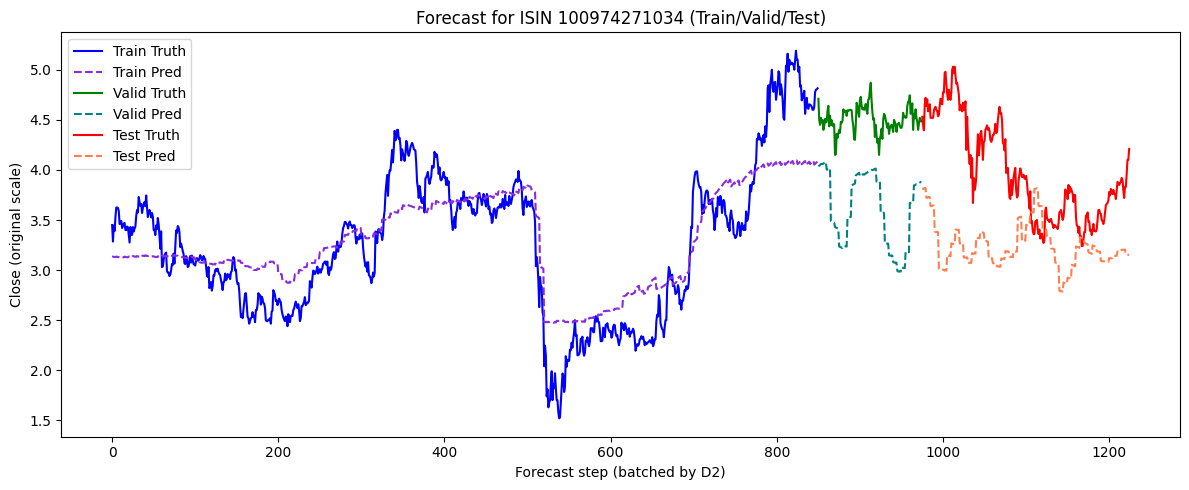

In [28]:
def plot_forecast_all(Yt_train, Yp_train,
                      Yt_valid, Yp_valid,
                      Yt_test, Yp_test,
                      isin_list, isin_code):
    isin_idx = isin_list.index(isin_code)

    plt.figure(figsize=(12,5))
    # Train
    plt.plot(Yt_train[:, isin_idx], label="Train Truth", color="blue")
    plt.plot(Yp_train[:, isin_idx], "--", label="Train Pred", color="blueviolet")

    # Valid
    plt.plot(range(len(Yt_train), len(Yt_train)+len(Yt_valid)),
             Yt_valid[:, isin_idx], label="Valid Truth", color="green")
    plt.plot(range(len(Yt_train), len(Yt_train)+len(Yt_valid)),
             Yp_valid[:, isin_idx], "--", label="Valid Pred", color="teal")

    # Test
    plt.plot(range(len(Yt_train)+len(Yt_valid), len(Yt_train)+len(Yt_valid)+len(Yt_test)),
             Yt_test[:, isin_idx], label="Test Truth", color="red")
    plt.plot(range(len(Yt_train)+len(Yt_valid), len(Yt_train)+len(Yt_valid)+len(Yt_test)),
             Yp_test[:, isin_idx], "--", label="Test Pred", color="coral")

    plt.title(f"Forecast for ISIN {isin_code} (Train/Valid/Test)")
    plt.xlabel("Forecast step (batched by D2)")
    plt.ylabel("Close (original scale)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pick ISIN
SELECTED_ISIN = None
if SELECTED_ISIN is None or SELECTED_ISIN not in isin_list:
    SELECTED_ISIN = isin_list[0]

plot_forecast_all(Yt_train, Yp_train,
                  Yt_valid, Yp_valid,
                  Yt_test, Yp_test,
                  isin_list, SELECTED_ISIN)

## Single Stock Model

### Weekly Model

In [29]:
D1 = 25                     # input lookback days
D2 = 5                      # output horizon days
TARGET_ISIN = "100974271034"  # <-- change this if you want
RANDOM_SEED = 42

In [30]:
# === Single-Ticker Dataset from existing tensor ===
# Choose target ticker (use any in isin_list)
assert TARGET_ISIN in isin_list, f"{TARGET_ISIN} not in isin_list!"
st_isin_idx = isin_list.index(TARGET_ISIN)

# Extract this ticker's standardized features and target (close = feature 0)
st_series = tensor[:, st_isin_idx, :]   # (days, features)
st_target = tensor[:, st_isin_idx, 0]   # (days,) close only (scaled)

def st_make_sequences(series, target, d1, d2, start, end):
    Xs, Ys = [], []
    max_start = end - (d1 + d2)
    for t in range(start, max_start):
        Xs.append(series[t:t+d1, :])        # (d1, features)
        Ys.append(target[t+d1:t+d1+d2])     # (d2,)
    if not Xs:
        return None, None
    X = torch.tensor(np.stack(Xs), dtype=torch.float32)
    Y = torch.tensor(np.stack(Ys), dtype=torch.float32)
    return X, Y

train_s, train_e = splits["train"]
valid_s, valid_e = splits["valid"]
test_s,  test_e  = splits["test"]

Xtr_st, Ytr_st = st_make_sequences(st_series, st_target, D1, D2, train_s, train_e)
Xva_st, Yva_st = st_make_sequences(st_series, st_target, D1, D2, valid_s, valid_e)
Xte_st, Yte_st = st_make_sequences(st_series, st_target, D1, D2, test_s,  test_e)

print("Single-ticker shapes:")
print("  Train:", None if Xtr_st is None else tuple(Xtr_st.shape),
      None if Ytr_st is None else tuple(Ytr_st.shape))
print("  Valid:", None if Xva_st is None else tuple(Xva_st.shape),
      None if Yva_st is None else tuple(Yva_st.shape))
print("  Test :", None if Xte_st is None else tuple(Xte_st.shape),
      None if Yte_st is None else tuple(Yte_st.shape))

# DataLoaders (don’t clash with your multi-ticker loaders)
st_batch = 128
st_train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xtr_st, Ytr_st), batch_size=st_batch, shuffle=True,
    num_workers=2, pin_memory=(device=="cuda")
)
st_valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xva_st, Yva_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)
st_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xte_st, Yte_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)


Single-ticker shapes:
  Train: (848, 25, 7) (848, 5)
  Valid: (95, 25, 7) (95, 5)
  Test : (222, 25, 7) (222, 5)


In [31]:
class LSTMOneTicker(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=None, num_layers=2, dropout=0.3):
        super().__init__()
        if output_dim is None:
            output_dim = D2
        self.lstm = nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim,
            num_layers=num_layers, batch_first=True, dropout=dropout
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)   # (B, D1, H)
        out = out[:, -1, :]     # last step (works fine for single ticker)
        return self.head(out)

st_model = LSTMOneTicker(input_dim=st_series.shape[-1], hidden_dim=64, output_dim=D2).to(device)
st_criterion = nn.SmoothL1Loss(beta=1.0)
st_optimizer = optim.Adam(st_model.parameters(), lr=1e-3, weight_decay=1e-3)
st_scheduler = optim.lr_scheduler.ReduceLROnPlateau(st_optimizer, mode="min", factor=0.5, patience=5)
st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\2641727328.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [32]:
st_epochs = 50
st_train_losses, st_valid_losses = [], []
st_max_grad = 0.5

for epoch in range(st_epochs):
    # Train
    st_model.train()
    run = 0.0
    for xb, yb in st_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        st_optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            pred = st_model(xb)
            loss = st_criterion(pred, yb)
        st_scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(st_model.parameters(), st_max_grad)
        st_scaler.step(st_optimizer)
        st_scaler.update()
        run += loss.item() * xb.size(0)
    tr_loss = run / len(st_train_loader.dataset)

    # Valid
    st_model.eval()
    run = 0.0
    with torch.no_grad():
        for xb, yb in st_valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                pred = st_model(xb)
                run += st_criterion(pred, yb).item() * xb.size(0)
    va_loss = run / len(st_valid_loader.dataset)

    st_scheduler.step(va_loss)
    st_train_losses.append(tr_loss); st_valid_losses.append(va_loss)
    print(f"[ST] Epoch {epoch+1:3d}/{st_epochs}: train {tr_loss:.6f}, valid {va_loss:.6f}, lr={st_optimizer.param_groups[0]['lr']:.2e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


[ST] Epoch   1/50: train 0.383763, valid 0.560122, lr=1.00e-03
[ST] Epoch   2/50: train 0.209556, valid 0.239976, lr=1.00e-03
[ST] Epoch   3/50: train 0.155652, valid 0.095758, lr=1.00e-03
[ST] Epoch   4/50: train 0.125290, valid 0.041247, lr=1.00e-03
[ST] Epoch   5/50: train 0.106224, valid 0.025106, lr=1.00e-03
[ST] Epoch   6/50: train 0.091319, valid 0.017676, lr=1.00e-03
[ST] Epoch   7/50: train 0.081401, valid 0.016248, lr=1.00e-03
[ST] Epoch   8/50: train 0.072993, valid 0.016547, lr=1.00e-03
[ST] Epoch   9/50: train 0.067691, valid 0.020205, lr=1.00e-03
[ST] Epoch  10/50: train 0.065604, valid 0.018159, lr=1.00e-03
[ST] Epoch  11/50: train 0.062141, valid 0.020360, lr=1.00e-03
[ST] Epoch  12/50: train 0.061340, valid 0.016781, lr=1.00e-03
[ST] Epoch  13/50: train 0.060078, valid 0.017703, lr=5.00e-04
[ST] Epoch  14/50: train 0.052564, valid 0.018163, lr=5.00e-04
[ST] Epoch  15/50: train 0.054593, valid 0.017333, lr=5.00e-04
[ST] Epoch  16/50: train 0.053987, valid 0.017152, lr=5

In [33]:
def st_rolling_predict_with_context(series, target, d1, d2, start_idx, end_idx, use_context=True):
    """
    series: (days, feats), target: (days,)
    Returns Y_true, Y_pred shaped (T, d2) contiguous over [start_idx, end_idx)
    using teacher forcing (no predicted feedback).
    """
    preds, trues = [], []
    t = start_idx - d1 if use_context else start_idx
    t = max(0, t)
    while t + d1 + d2 <= end_idx:
        x_win = series[t:t+d1, :][None, ...]     # (1, d1, feats)
        x_win = torch.tensor(x_win, dtype=torch.float32, device=device)
        with torch.no_grad():
            y_pred = st_model(x_win).cpu().numpy().reshape(d2)
        y_true = target[t+d1:t+d1+d2]
        preds.append(y_pred)
        trues.append(y_true)
        t += d2
    return np.vstack(trues), np.vstack(preds)

# Train (no earlier context), Valid/Test (use context from previous split)
Y_true_tr_st, Y_pred_tr_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, train_s, train_e, use_context=False)
Y_true_va_st, Y_pred_va_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, valid_s, valid_e, use_context=True)
Y_true_te_st, Y_pred_te_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, test_s,  test_e,  use_context=True)

print("Single-ticker pred/true shapes:")
print("  Train:", Y_true_tr_st.shape, Y_pred_tr_st.shape)
print("  Valid:", Y_true_va_st.shape, Y_pred_va_st.shape)
print("  Test :", Y_true_te_st.shape, Y_pred_te_st.shape)


Single-ticker pred/true shapes:
  Train: (170, 5) (170, 5)
  Valid: (25, 5) (25, 5)
  Test : (50, 5) (50, 5)


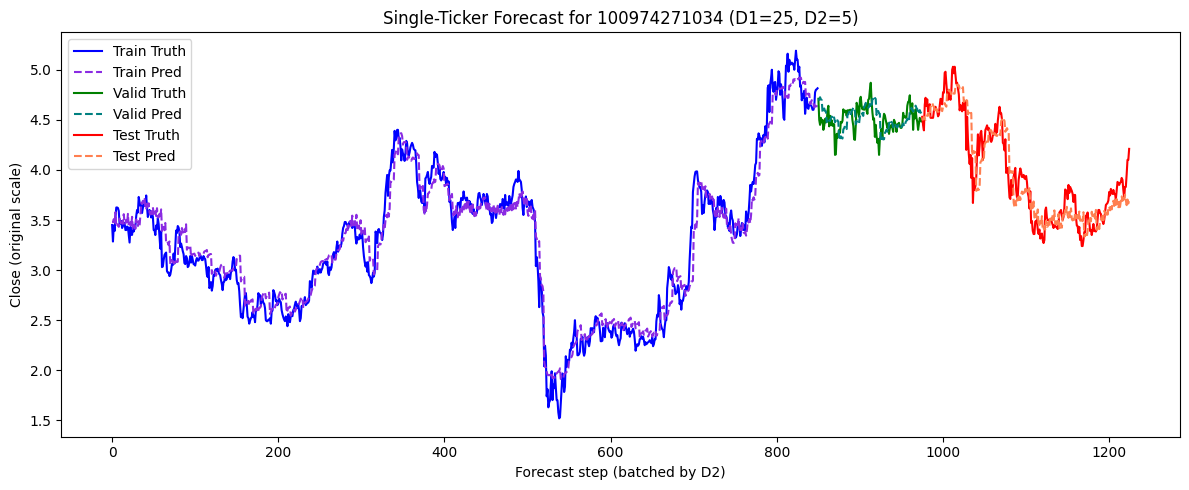

In [34]:
# Unscale helper for this ticker (z-score -> price units)
st_mu  = stock_mean[TARGET_ISIN]
st_std = stock_std[TARGET_ISIN]

def st_unscale_close(y_scaled):
    # y_scaled: (T, D2)
    return y_scaled * st_std + st_mu

Yt_tr = st_unscale_close(Y_true_tr_st)
Yp_tr = st_unscale_close(Y_pred_tr_st)
Yt_va = st_unscale_close(Y_true_va_st)
Yp_va = st_unscale_close(Y_pred_va_st)
Yt_te = st_unscale_close(Y_true_te_st)
Yp_te = st_unscale_close(Y_pred_te_st)

plt.figure(figsize=(12,5))
# Train
plt.plot(Yt_tr.reshape(-1), label="Train Truth", color="blue")
plt.plot(Yp_tr.reshape(-1), "--", label="Train Pred", color="blueviolet")

# Valid
off = len(Yt_tr.reshape(-1))
plt.plot(range(off, off+len(Yt_va.reshape(-1))), Yt_va.reshape(-1), label="Valid Truth", color="green")
plt.plot(range(off, off+len(Yp_va.reshape(-1))), Yp_va.reshape(-1), "--", label="Valid Pred", color="teal")

# Test
off2 = off + len(Yt_va.reshape(-1))
plt.plot(range(off2, off2+len(Yt_te.reshape(-1))), Yt_te.reshape(-1), label="Test Truth", color="red")
plt.plot(range(off2, off2+len(Yp_te.reshape(-1))), Yp_te.reshape(-1), "--", label="Test Pred", color="coral")

plt.title(f"Single-Ticker Forecast for {TARGET_ISIN} (D1={D1}, D2={D2})")
plt.xlabel("Forecast step (batched by D2)")
plt.ylabel("Close (original scale)")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
mse = mean_squared_error(Yt_te, Yp_te)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Yt_te, Yp_te)

print(f"MSE: {mse:.6f}\nRMSE: {rmse:.6f}\nMAE: {mae:.6f}")

MSE: 0.038089
RMSE: 0.195164
MAE: 0.153928


Train RMSE: 0.0887
Validation RMSE: 0.1266
Test RMSE: 0.1715


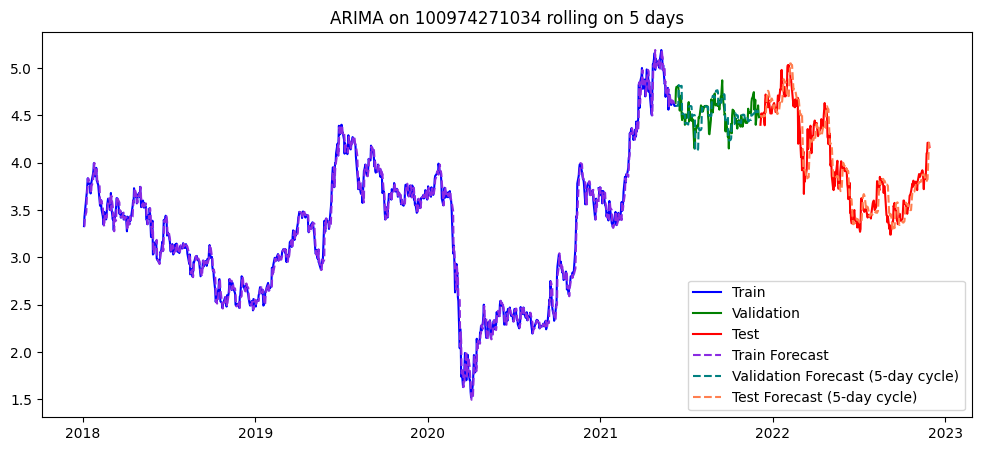

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# --- Prepare time series ---
target_df = close_df[close_df["ISIN"] == TARGET_ISIN].copy()
series = target_df["closePrice"].dropna()
series.index = pd.to_datetime(target_df["timestamp"].dropna())
series = series.asfreq("B")

# --- Train / Validation / Test split (70/10/20) ---
n = len(series)
train_end = int(n * 0.7)
valid_end = int(n * 0.8)

train = series.iloc[:train_end]
valid = series.iloc[train_end:valid_end]
test  = series.iloc[valid_end:]

# --- Fit ARIMA on training data ---
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(method_kwargs={"maxiter":100, "disp":0})

# --- In-sample fit (train RMSE) ---
train_pred = model_fit.fittedvalues

train = train[1:]
train_pred = train_pred[1:]

aligned_train = pd.concat([train, train_pred], axis=1).dropna()
aligned_train.columns = ["actual", "predicted"]

train_rmse = np.sqrt(mean_squared_error(aligned_train["actual"], aligned_train["predicted"]))
print(f"Train RMSE: {train_rmse:.4f}")

# --- Rolling 5-day forecast on validation set ---
val_predictions = []
i = 0
while i < len(valid):
    steps = min(5, len(valid) - i)
    forecast = model_fit.forecast(steps=steps)
    val_predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(valid.iloc[i:i+steps], refit=False)
    i += steps

val_pred_series = pd.Series(val_predictions, index=valid.index)
val_rmse = np.sqrt(mean_squared_error(valid, val_pred_series))
print(f"Validation RMSE: {val_rmse:.4f}")

# --- Rolling 5-day forecast on test set ---
predictions = []
i = 0
while i < len(test):
    steps = min(5, len(test) - i)
    forecast = model_fit.forecast(steps=steps)
    predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(test.iloc[i:i+steps], refit=False)
    i += steps

pred_series = pd.Series(predictions, index=test.index)
test_rmse = np.sqrt(mean_squared_error(test, pred_series))
print(f"Test RMSE: {test_rmse:.4f}")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(valid.index, valid, label="Validation", color="green")
plt.plot(test.index, test, label="Test", color="red")

plt.plot(train.index, train_pred, label="Train Forecast", color="blueviolet", linestyle="--")
plt.plot(valid.index, val_pred_series, label="Validation Forecast (5-day cycle)", color="teal", linestyle="--")
plt.plot(test.index, pred_series, label="Test Forecast (5-day cycle)", color="coral", linestyle="--")

plt.legend()
plt.title(f"ARIMA on {TARGET_ISIN} rolling on 5 days")
plt.show()


LSTM Test RMSE: 0.1936 <br>
ARIMA Test RMSE: 0.1715

### Daily Model

In [37]:
D1 = 5                     # input lookback days
D2 = 1                      # output horizon days

In [38]:
train_s, train_e = splits["train"]
valid_s, valid_e = splits["valid"]
test_s,  test_e  = splits["test"]

Xtr_st, Ytr_st = st_make_sequences(st_series, st_target, D1, D2, train_s, train_e)
Xva_st, Yva_st = st_make_sequences(st_series, st_target, D1, D2, valid_s, valid_e)
Xte_st, Yte_st = st_make_sequences(st_series, st_target, D1, D2, test_s,  test_e)

print("Single-ticker shapes:")
print("  Train:", None if Xtr_st is None else tuple(Xtr_st.shape),
      None if Ytr_st is None else tuple(Ytr_st.shape))
print("  Valid:", None if Xva_st is None else tuple(Xva_st.shape),
      None if Yva_st is None else tuple(Yva_st.shape))
print("  Test :", None if Xte_st is None else tuple(Xte_st.shape),
      None if Yte_st is None else tuple(Yte_st.shape))

# DataLoaders (don’t clash with your multi-ticker loaders)
st_batch = 128
st_train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xtr_st, Ytr_st), batch_size=st_batch, shuffle=True,
    num_workers=2, pin_memory=(device=="cuda")
)
st_valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xva_st, Yva_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)
st_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xte_st, Yte_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)


Single-ticker shapes:
  Train: (872, 5, 7) (872, 1)
  Valid: (119, 5, 7) (119, 1)
  Test : (246, 5, 7) (246, 1)


In [39]:
class LSTMOneTicker(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=None, num_layers=2, dropout=0.3):
        super().__init__()
        if output_dim is None:
            output_dim = D2
        self.lstm = nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim,
            num_layers=num_layers, batch_first=True, dropout=dropout
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)   # (B, D1, H)
        out = out[:, -1, :]     # last step (works fine for single ticker)
        return self.head(out)

st_model = LSTMOneTicker(input_dim=st_series.shape[-1], hidden_dim=64, output_dim=D2).to(device)
st_criterion = nn.SmoothL1Loss(beta=1.0)
st_optimizer = optim.Adam(st_model.parameters(), lr=1e-3, weight_decay=1e-3)
st_scheduler = optim.lr_scheduler.ReduceLROnPlateau(st_optimizer, mode="min", factor=0.5, patience=5)
st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\2641727328.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [40]:
st_epochs = 50
st_train_losses, st_valid_losses = [], []
st_max_grad = 0.5

for epoch in range(st_epochs):
    # Train
    st_model.train()
    run = 0.0
    for xb, yb in st_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        st_optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            pred = st_model(xb)
            loss = st_criterion(pred, yb)
        st_scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(st_model.parameters(), st_max_grad)
        st_scaler.step(st_optimizer)
        st_scaler.update()
        run += loss.item() * xb.size(0)
    tr_loss = run / len(st_train_loader.dataset)

    # Valid
    st_model.eval()
    run = 0.0
    with torch.no_grad():
        for xb, yb in st_valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                pred = st_model(xb)
                run += st_criterion(pred, yb).item() * xb.size(0)
    va_loss = run / len(st_valid_loader.dataset)

    st_scheduler.step(va_loss)
    st_train_losses.append(tr_loss); st_valid_losses.append(va_loss)
    print(f"[ST] Epoch {epoch+1:3d}/{st_epochs}: train {tr_loss:.6f}, valid {va_loss:.6f}, lr={st_optimizer.param_groups[0]['lr']:.2e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


[ST] Epoch   1/50: train 0.262881, valid 0.131187, lr=1.00e-03
[ST] Epoch   2/50: train 0.116077, valid 0.012559, lr=1.00e-03
[ST] Epoch   3/50: train 0.096170, valid 0.012618, lr=1.00e-03
[ST] Epoch   4/50: train 0.070541, valid 0.011652, lr=1.00e-03
[ST] Epoch   5/50: train 0.060553, valid 0.011516, lr=1.00e-03
[ST] Epoch   6/50: train 0.057269, valid 0.028338, lr=1.00e-03
[ST] Epoch   7/50: train 0.054487, valid 0.011073, lr=1.00e-03
[ST] Epoch   8/50: train 0.049749, valid 0.023245, lr=1.00e-03
[ST] Epoch   9/50: train 0.045310, valid 0.010471, lr=1.00e-03
[ST] Epoch  10/50: train 0.040673, valid 0.010669, lr=1.00e-03
[ST] Epoch  11/50: train 0.034982, valid 0.010123, lr=1.00e-03
[ST] Epoch  12/50: train 0.039285, valid 0.010380, lr=1.00e-03
[ST] Epoch  13/50: train 0.035149, valid 0.012338, lr=1.00e-03
[ST] Epoch  14/50: train 0.037692, valid 0.010731, lr=1.00e-03
[ST] Epoch  15/50: train 0.038810, valid 0.012637, lr=1.00e-03
[ST] Epoch  16/50: train 0.038136, valid 0.010322, lr=1

In [41]:
# Train (no earlier context), Valid/Test (use context from previous split)
Y_true_tr_st, Y_pred_tr_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, train_s, train_e, use_context=False)
Y_true_va_st, Y_pred_va_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, valid_s, valid_e, use_context=True)
Y_true_te_st, Y_pred_te_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, test_s,  test_e,  use_context=True)

print("Single-ticker pred/true shapes:")
print("  Train:", Y_true_tr_st.shape, Y_pred_tr_st.shape)
print("  Valid:", Y_true_va_st.shape, Y_pred_va_st.shape)
print("  Test :", Y_true_te_st.shape, Y_pred_te_st.shape)

Single-ticker pred/true shapes:
  Train: (873, 1) (873, 1)
  Valid: (125, 1) (125, 1)
  Test : (252, 1) (252, 1)


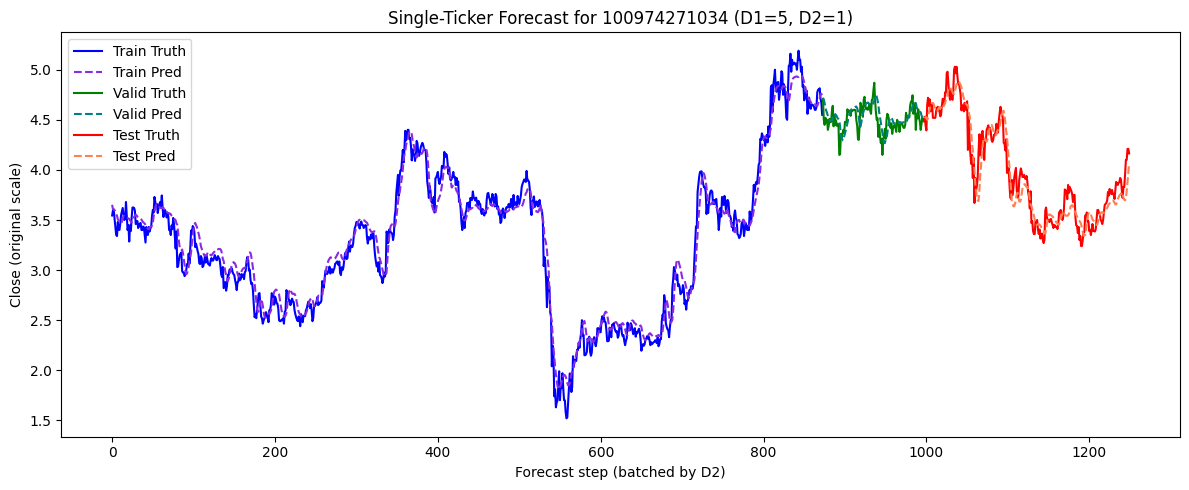

In [42]:
# Unscale helper for this ticker (z-score -> price units)
st_mu  = stock_mean[TARGET_ISIN]
st_std = stock_std[TARGET_ISIN]

def st_unscale_close(y_scaled):
    # y_scaled: (T, D2)
    return y_scaled * st_std + st_mu

Yt_tr = st_unscale_close(Y_true_tr_st)
Yp_tr = st_unscale_close(Y_pred_tr_st)
Yt_va = st_unscale_close(Y_true_va_st)
Yp_va = st_unscale_close(Y_pred_va_st)
Yt_te = st_unscale_close(Y_true_te_st)
Yp_te = st_unscale_close(Y_pred_te_st)

plt.figure(figsize=(12,5))
# Train
plt.plot(Yt_tr.reshape(-1), label="Train Truth", color="blue")
plt.plot(Yp_tr.reshape(-1), "--", label="Train Pred", color="blueviolet")

# Valid
off = len(Yt_tr.reshape(-1))
plt.plot(range(off, off+len(Yt_va.reshape(-1))), Yt_va.reshape(-1), label="Valid Truth", color="green")
plt.plot(range(off, off+len(Yp_va.reshape(-1))), Yp_va.reshape(-1), "--", label="Valid Pred", color="teal")

# Test
off2 = off + len(Yt_va.reshape(-1))
plt.plot(range(off2, off2+len(Yt_te.reshape(-1))), Yt_te.reshape(-1), label="Test Truth", color="red")
plt.plot(range(off2, off2+len(Yp_te.reshape(-1))), Yp_te.reshape(-1), "--", label="Test Pred", color="coral")

plt.title(f"Single-Ticker Forecast for {TARGET_ISIN} (D1={D1}, D2={D2})")
plt.xlabel("Forecast step (batched by D2)")
plt.ylabel("Close (original scale)")
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
mse = mean_squared_error(Yt_te, Yp_te)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Yt_te, Yp_te)

print(f"MSE: {mse:.6f}\nRMSE: {rmse:.6f}\nMAE: {mae:.6f}")

MSE: 0.023278
RMSE: 0.152572
MAE: 0.120192


Train RMSE: 0.0887
Validation RMSE: 0.1266
Test RMSE: 0.1022


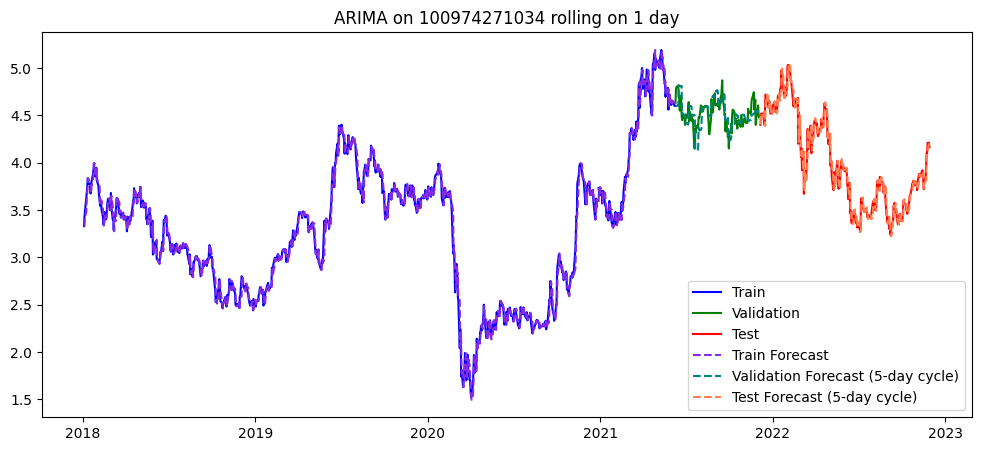

In [44]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# --- Prepare time series ---
target_df = close_df[close_df["ISIN"] == TARGET_ISIN].copy()
series = target_df["closePrice"].dropna()
series.index = pd.to_datetime(target_df["timestamp"].dropna())
series = series.asfreq("B")

# --- Train / Validation / Test split (70/10/20) ---
n = len(series)
train_end = int(n * 0.7)
valid_end = int(n * 0.8)

train = series.iloc[:train_end]
valid = series.iloc[train_end:valid_end]
test  = series.iloc[valid_end:]

# --- Fit ARIMA on training data ---
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(method_kwargs={"maxiter":100, "disp":0})

# --- In-sample fit (train RMSE) ---
train_pred = model_fit.fittedvalues

train = train[1:]
train_pred = train_pred[1:]

aligned_train = pd.concat([train, train_pred], axis=1).dropna()
aligned_train.columns = ["actual", "predicted"]

train_rmse = np.sqrt(mean_squared_error(aligned_train["actual"], aligned_train["predicted"]))
print(f"Train RMSE: {train_rmse:.4f}")

# --- Rolling 5-day forecast on validation set ---
val_predictions = []
i = 0
while i < len(valid):
    steps = min(5, len(valid) - i)
    forecast = model_fit.forecast(steps=steps)
    val_predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(valid.iloc[i:i+steps], refit=False)
    i += steps

val_pred_series = pd.Series(val_predictions, index=valid.index)
val_rmse = np.sqrt(mean_squared_error(valid, val_pred_series))
print(f"Validation RMSE: {val_rmse:.4f}")

# --- Rolling 5-day forecast on test set ---
predictions = []
i = 0
while i < len(test):
    steps = 1
    forecast = model_fit.forecast(steps=steps)
    predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(test.iloc[i:i+steps], refit=False)
    i += steps

pred_series = pd.Series(predictions, index=test.index)
test_rmse = np.sqrt(mean_squared_error(test, pred_series))
print(f"Test RMSE: {test_rmse:.4f}")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(valid.index, valid, label="Validation", color="green")
plt.plot(test.index, test, label="Test", color="red")

plt.plot(train.index, train_pred, label="Train Forecast", color="blueviolet", linestyle="--")
plt.plot(valid.index, val_pred_series, label="Validation Forecast (5-day cycle)", color="teal", linestyle="--")
plt.plot(test.index, pred_series, label="Test Forecast (5-day cycle)", color="coral", linestyle="--")

plt.legend()
plt.title(f"ARIMA on {TARGET_ISIN} rolling on 1 day")
plt.show()


LSTM Test RMSE: 0.1549 <br>
ARIMA Test RMSE: 0.1022

### Monthly Model

In [45]:
D1 = 100                     # input lookback days
D2 = 20                      # output horizon days

In [46]:
train_s, train_e = splits["train"]
valid_s, valid_e = splits["valid"]
test_s,  test_e  = splits["test"]

Xtr_st, Ytr_st = st_make_sequences(st_series, st_target, D1, D2, train_s, train_e)
Xva_st, Yva_st = st_make_sequences(st_series, st_target, D1, D2, valid_s, valid_e)
Xte_st, Yte_st = st_make_sequences(st_series, st_target, D1, D2, test_s,  test_e)

print("Single-ticker shapes:")
print("  Train:", None if Xtr_st is None else tuple(Xtr_st.shape),
      None if Ytr_st is None else tuple(Ytr_st.shape))
print("  Valid:", None if Xva_st is None else tuple(Xva_st.shape),
      None if Yva_st is None else tuple(Yva_st.shape))
print("  Test :", None if Xte_st is None else tuple(Xte_st.shape),
      None if Yte_st is None else tuple(Yte_st.shape))

# DataLoaders (don’t clash with your multi-ticker loaders)
st_batch = 128
st_train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xtr_st, Ytr_st), batch_size=st_batch, shuffle=True,
    num_workers=2, pin_memory=(device=="cuda")
)
st_valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xva_st, Yva_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)
st_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xte_st, Yte_st), batch_size=st_batch, shuffle=False,
    num_workers=2, pin_memory=(device=="cuda")
)


Single-ticker shapes:
  Train: (758, 100, 7) (758, 20)
  Valid: (5, 100, 7) (5, 20)
  Test : (132, 100, 7) (132, 20)


In [47]:
class LSTMOneTicker(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=None, num_layers=2, dropout=0.3):
        super().__init__()
        if output_dim is None:
            output_dim = D2
        self.lstm = nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim,
            num_layers=num_layers, batch_first=True, dropout=dropout
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)   # (B, D1, H)
        out = out[:, -1, :]     # last step (works fine for single ticker)
        return self.head(out)

st_model = LSTMOneTicker(input_dim=st_series.shape[-1], hidden_dim=64, output_dim=D2).to(device)
st_criterion = nn.SmoothL1Loss(beta=1.0)
st_optimizer = optim.Adam(st_model.parameters(), lr=1e-3, weight_decay=1e-3)
st_scheduler = optim.lr_scheduler.ReduceLROnPlateau(st_optimizer, mode="min", factor=0.5, patience=5)
st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\2641727328.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  st_scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [48]:
st_epochs = 50
st_train_losses, st_valid_losses = [], []
st_max_grad = 0.5

for epoch in range(st_epochs):
    # Train
    st_model.train()
    run = 0.0
    for xb, yb in st_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        st_optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            pred = st_model(xb)
            loss = st_criterion(pred, yb)
        st_scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(st_model.parameters(), st_max_grad)
        st_scaler.step(st_optimizer)
        st_scaler.update()
        run += loss.item() * xb.size(0)
    tr_loss = run / len(st_train_loader.dataset)

    # Valid
    st_model.eval()
    run = 0.0
    with torch.no_grad():
        for xb, yb in st_valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                pred = st_model(xb)
                run += st_criterion(pred, yb).item() * xb.size(0)
    va_loss = run / len(st_valid_loader.dataset)

    st_scheduler.step(va_loss)
    st_train_losses.append(tr_loss); st_valid_losses.append(va_loss)
    print(f"[ST] Epoch {epoch+1:3d}/{st_epochs}: train {tr_loss:.6f}, valid {va_loss:.6f}, lr={st_optimizer.param_groups[0]['lr']:.2e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


[ST] Epoch   1/50: train 0.462706, valid 0.760072, lr=1.00e-03
[ST] Epoch   2/50: train 0.344917, valid 0.612690, lr=1.00e-03
[ST] Epoch   3/50: train 0.268522, valid 0.466428, lr=1.00e-03
[ST] Epoch   4/50: train 0.228285, valid 0.347736, lr=1.00e-03
[ST] Epoch   5/50: train 0.194479, valid 0.267862, lr=1.00e-03
[ST] Epoch   6/50: train 0.172274, valid 0.182813, lr=1.00e-03
[ST] Epoch   7/50: train 0.151754, valid 0.114301, lr=1.00e-03
[ST] Epoch   8/50: train 0.148954, valid 0.056646, lr=1.00e-03
[ST] Epoch   9/50: train 0.126010, valid 0.035561, lr=1.00e-03
[ST] Epoch  10/50: train 0.125021, valid 0.046307, lr=1.00e-03
[ST] Epoch  11/50: train 0.115292, valid 0.031165, lr=1.00e-03
[ST] Epoch  12/50: train 0.110530, valid 0.023818, lr=1.00e-03
[ST] Epoch  13/50: train 0.103354, valid 0.012229, lr=1.00e-03
[ST] Epoch  14/50: train 0.101398, valid 0.044593, lr=1.00e-03
[ST] Epoch  15/50: train 0.099117, valid 0.062086, lr=1.00e-03
[ST] Epoch  16/50: train 0.098772, valid 0.027204, lr=1

In [49]:
st_epochs = 50
st_train_losses, st_valid_losses = [], []
st_max_grad = 0.5

for epoch in range(st_epochs):
    # Train
    st_model.train()
    run = 0.0
    for xb, yb in st_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        st_optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            pred = st_model(xb)
            loss = st_criterion(pred, yb)
        st_scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(st_model.parameters(), st_max_grad)
        st_scaler.step(st_optimizer)
        st_scaler.update()
        run += loss.item() * xb.size(0)
    tr_loss = run / len(st_train_loader.dataset)

    # Valid
    st_model.eval()
    run = 0.0
    with torch.no_grad():
        for xb, yb in st_valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                pred = st_model(xb)
                run += st_criterion(pred, yb).item() * xb.size(0)
    va_loss = run / len(st_valid_loader.dataset)

    st_scheduler.step(va_loss)
    st_train_losses.append(tr_loss); st_valid_losses.append(va_loss)
    print(f"[ST] Epoch {epoch+1:3d}/{st_epochs}: train {tr_loss:.6f}, valid {va_loss:.6f}, lr={st_optimizer.param_groups[0]['lr']:.2e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_47292\3491677961.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


[ST] Epoch   1/50: train 0.078991, valid 0.023678, lr=1.56e-05
[ST] Epoch   2/50: train 0.080393, valid 0.023434, lr=1.56e-05
[ST] Epoch   3/50: train 0.076881, valid 0.023621, lr=1.56e-05
[ST] Epoch   4/50: train 0.078711, valid 0.023510, lr=1.56e-05
[ST] Epoch   5/50: train 0.077583, valid 0.022135, lr=1.56e-05
[ST] Epoch   6/50: train 0.079063, valid 0.021442, lr=7.81e-06
[ST] Epoch   7/50: train 0.075597, valid 0.021249, lr=7.81e-06
[ST] Epoch   8/50: train 0.079240, valid 0.021640, lr=7.81e-06
[ST] Epoch   9/50: train 0.077546, valid 0.021897, lr=7.81e-06
[ST] Epoch  10/50: train 0.080147, valid 0.022118, lr=7.81e-06
[ST] Epoch  11/50: train 0.076208, valid 0.022359, lr=7.81e-06
[ST] Epoch  12/50: train 0.078637, valid 0.022168, lr=3.91e-06
[ST] Epoch  13/50: train 0.078170, valid 0.021972, lr=3.91e-06
[ST] Epoch  14/50: train 0.078150, valid 0.021815, lr=3.91e-06
[ST] Epoch  15/50: train 0.080218, valid 0.021758, lr=3.91e-06
[ST] Epoch  16/50: train 0.079727, valid 0.021703, lr=3

In [50]:
# Train (no earlier context), Valid/Test (use context from previous split)
Y_true_tr_st, Y_pred_tr_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, train_s, train_e, use_context=False)
Y_true_va_st, Y_pred_va_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, valid_s, valid_e, use_context=True)
Y_true_te_st, Y_pred_te_st = st_rolling_predict_with_context(st_series, st_target, D1, D2, test_s,  test_e,  use_context=True)

print("Single-ticker pred/true shapes:")
print("  Train:", Y_true_tr_st.shape, Y_pred_tr_st.shape)
print("  Valid:", Y_true_va_st.shape, Y_pred_va_st.shape)
print("  Test :", Y_true_te_st.shape, Y_pred_te_st.shape)

Single-ticker pred/true shapes:
  Train: (38, 20) (38, 20)
  Valid: (6, 20) (6, 20)
  Test : (12, 20) (12, 20)


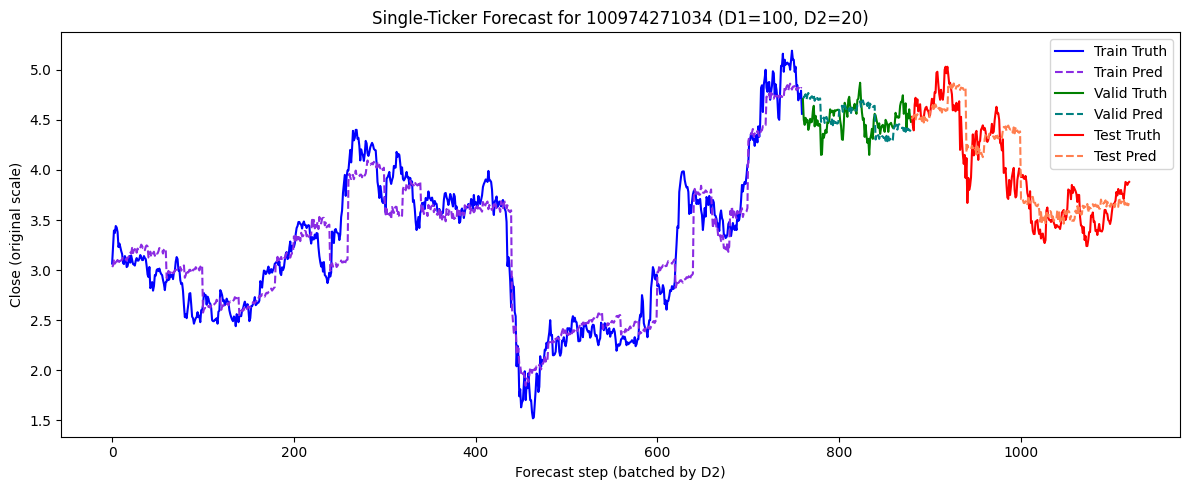

In [51]:
# Unscale helper for this ticker (z-score -> price units)
st_mu  = stock_mean[TARGET_ISIN]
st_std = stock_std[TARGET_ISIN]

def st_unscale_close(y_scaled):
    # y_scaled: (T, D2)
    return y_scaled * st_std + st_mu

Yt_tr = st_unscale_close(Y_true_tr_st)
Yp_tr = st_unscale_close(Y_pred_tr_st)
Yt_va = st_unscale_close(Y_true_va_st)
Yp_va = st_unscale_close(Y_pred_va_st)
Yt_te = st_unscale_close(Y_true_te_st)
Yp_te = st_unscale_close(Y_pred_te_st)

plt.figure(figsize=(12,5))
# Train
plt.plot(Yt_tr.reshape(-1), label="Train Truth", color="blue")
plt.plot(Yp_tr.reshape(-1), "--", label="Train Pred", color="blueviolet")

# Valid
off = len(Yt_tr.reshape(-1))
plt.plot(range(off, off+len(Yt_va.reshape(-1))), Yt_va.reshape(-1), label="Valid Truth", color="green")
plt.plot(range(off, off+len(Yp_va.reshape(-1))), Yp_va.reshape(-1), "--", label="Valid Pred", color="teal")

# Test
off2 = off + len(Yt_va.reshape(-1))
plt.plot(range(off2, off2+len(Yt_te.reshape(-1))), Yt_te.reshape(-1), label="Test Truth", color="red")
plt.plot(range(off2, off2+len(Yp_te.reshape(-1))), Yp_te.reshape(-1), "--", label="Test Pred", color="coral")

plt.title(f"Single-Ticker Forecast for {TARGET_ISIN} (D1={D1}, D2={D2})")
plt.xlabel("Forecast step (batched by D2)")
plt.ylabel("Close (original scale)")
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
mse = mean_squared_error(Yt_te, Yp_te)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Yt_te, Yp_te)

print(f"MSE: {mse:.6f}\nRMSE: {rmse:.6f}\nMAE: {mae:.6f}")

MSE: 0.066139
RMSE: 0.257176
MAE: 0.197111


Train RMSE: 0.0887
Validation RMSE: 0.1266
Test RMSE: 0.2742


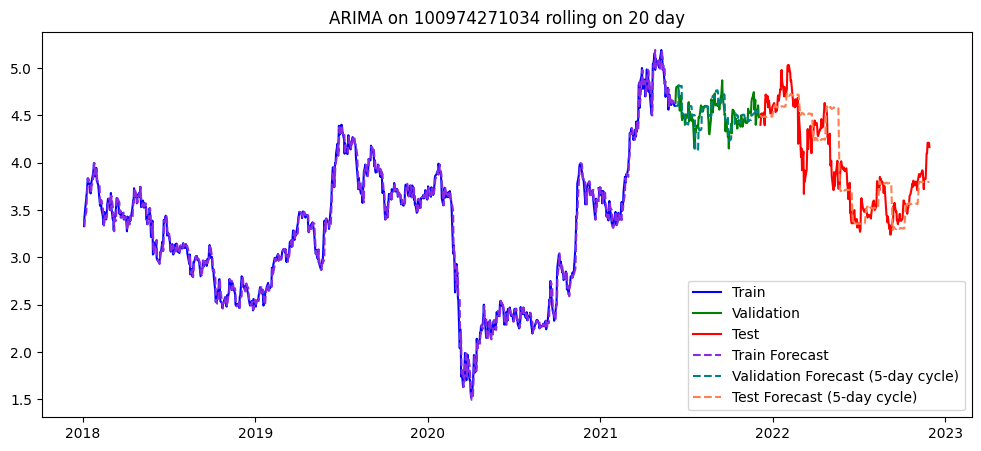

In [53]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# --- Prepare time series ---
target_df = close_df[close_df["ISIN"] == TARGET_ISIN].copy()
series = target_df["closePrice"].dropna()
series.index = pd.to_datetime(target_df["timestamp"].dropna())
series = series.asfreq("B")

# --- Train / Validation / Test split (70/10/20) ---
n = len(series)
train_end = int(n * 0.7)
valid_end = int(n * 0.8)

train = series.iloc[:train_end]
valid = series.iloc[train_end:valid_end]
test  = series.iloc[valid_end:]

# --- Fit ARIMA on training data ---
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(method_kwargs={"maxiter":100, "disp":0})

# --- In-sample fit (train RMSE) ---
train_pred = model_fit.fittedvalues

train = train[1:]
train_pred = train_pred[1:]

aligned_train = pd.concat([train, train_pred], axis=1).dropna()
aligned_train.columns = ["actual", "predicted"]

train_rmse = np.sqrt(mean_squared_error(aligned_train["actual"], aligned_train["predicted"]))
print(f"Train RMSE: {train_rmse:.4f}")

# --- Rolling 5-day forecast on validation set ---
val_predictions = []
i = 0
while i < len(valid):
    steps = min(5, len(valid) - i)
    forecast = model_fit.forecast(steps=steps)
    val_predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(valid.iloc[i:i+steps], refit=False)
    i += steps

val_pred_series = pd.Series(val_predictions, index=valid.index)
val_rmse = np.sqrt(mean_squared_error(valid, val_pred_series))
print(f"Validation RMSE: {val_rmse:.4f}")

# --- Rolling 5-day forecast on test set ---
predictions = []
i = 0
while i < len(test):
    steps = min(20, len(test) - i)
    forecast = model_fit.forecast(steps=steps)
    predictions.extend(forecast)

    # update state with true obs (no refit)
    model_fit = model_fit.append(test.iloc[i:i+steps], refit=False)
    i += steps

pred_series = pd.Series(predictions, index=test.index)
test_rmse = np.sqrt(mean_squared_error(test, pred_series))
print(f"Test RMSE: {test_rmse:.4f}")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(valid.index, valid, label="Validation", color="green")
plt.plot(test.index, test, label="Test", color="red")

plt.plot(train.index, train_pred, label="Train Forecast", color="blueviolet", linestyle="--")
plt.plot(valid.index, val_pred_series, label="Validation Forecast (5-day cycle)", color="teal", linestyle="--")
plt.plot(test.index, pred_series, label="Test Forecast (5-day cycle)", color="coral", linestyle="--")

plt.legend()
plt.title(f"ARIMA on {TARGET_ISIN} rolling on 20 day")
plt.show()


LSTM Test RMSE: 0.2578 <br>
ARIMA Test RMSE: 0.2742